=== Geometry and Flow ===
L = 0.300 m
Cross-sectional area A = 3.141593e-04 m^2
Q = 2.000e-08 m^3/s

=== Velocities ===
Darcy velocity q = 6.366e-05 m/s  (~0.382 cm/min)
Pore-water velocity v = 1.592e-04 m/s  (~0.955 cm/min)
Advective travel time L/v ≈ 31.42 minutes

=== Data Preview ===
   time_min  C_obs_mgL
0       1.0   2.483571
1       2.0   0.000000
2       3.0   3.238443
3       4.0   7.615149
4       5.0   0.000000

Inferred median sampling period ≈ 60 seconds

=== Fitted Parameters ===
Fitted D = 4.387e-07 m^2/s
Fitted M/A = 4.105 (mg/m^2 units)

=== Dimensionless Number ===
Peclet number Pe = 108.82



/tmp/ipykernel_19322/96573357.py:276: RuntimeWarning: invalid value encountered in sqrt
  C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L - v * t)**2 / (4 * D * t))


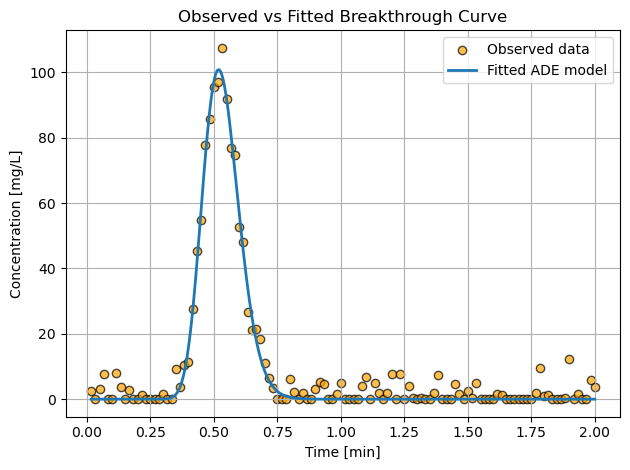

In [1]:
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# ---------------------------------------------------------------------
# USER SETTINGS (NEW)
# ---------------------------------------------------------------------
# Keep your existing workflow, but you can now control sampling/interval behavior here.

DATA_FILE = "breakthrough_data.csv"

# If your time column is numeric elapsed time, set TIME_COL + TIME_UNIT.
# Examples: TIME_UNIT = "s", "min", "h", "d", "w"
TIME_COL = "time_min"
TIME_UNIT = "min"

# If instead you have real timestamps (recommended for long experiments), set DATETIME_COL
# and leave TIME_COL/TIME_UNIT alone (they'll be ignored).
# Example: DATETIME_COL = "timestamp"  # e.g., 2026-02-03 14:05:00
DATETIME_COL = None

# Optional: resample/aggregate your observations to a regular interval.
# Examples: "5 s", "2 hours", "10 days", "1 week", "3 months", "1 year"
# Set to None to use the data exactly as provided (original behavior).
SAMPLE_EVERY = None

# How to aggregate concentration values that fall into the same interval bin
# Options: "mean", "median", "first", "last"
AGG = "mean"

import re

def _parse_interval(interval):
    """Parse human-friendly intervals like '5 s', '2 hours', '10 days', '3 months', '1 year'.

    Returns
    -------
    (kind, n, unit)
        kind: 'fixed' for seconds/minutes/hours/days/weeks (constant duration),
              'calendar' for months/years (variable duration, best with real timestamps)
        n: float for fixed, int for calendar
        unit: canonical unit string ('s','min','h','d','w','month','year')
    """
    if interval is None:
        return None
    s = str(interval).strip().lower()
    # allow '5s' or '5 s' or '5 seconds'
    m = re.match(r"^\s*(\d+(?:\.\d+)?)\s*([a-zA-Z]+)\s*$", s)
    if not m:
        # try removing spaces like '5seconds'
        m = re.match(r"^\s*(\d+(?:\.\d+)?)\s*([a-zA-Z]+)\s*$", s.replace(" ", ""))
    if not m:
        raise ValueError(f"Could not parse interval: {interval!r}. Examples: '5 s', '2 hours', '10 days'.")

    n = float(m.group(1))
    u = m.group(2)

    # normalize unit tokens
    unit_map = {
        "s": "s", "sec": "s", "secs": "s", "second": "s", "seconds": "s",
        "m": "min", "min": "min", "mins": "min", "minute": "min", "minutes": "min",
        "h": "h", "hr": "h", "hrs": "h", "hour": "h", "hours": "h",
        "d": "d", "day": "d", "days": "d",
        "w": "w", "wk": "w", "wks": "w", "week": "w", "weeks": "w",
        "mo": "month", "mon": "month", "month": "month", "months": "month",
        "y": "year", "yr": "year", "yrs": "year", "year": "year", "years": "year",
    }
    if u not in unit_map:
        raise ValueError(f"Unknown unit {u!r} in interval {interval!r}.")

    unit = unit_map[u]
    if unit in {"month", "year"}:
        if abs(n - round(n)) > 1e-9:
            raise ValueError("Months/years must be whole numbers (e.g., '3 months', '1 year').")
        return ("calendar", int(round(n)), unit)
    return ("fixed", n, unit)

def _elapsed_to_seconds(values, unit):
    """Convert numeric elapsed time to seconds."""
    unit = str(unit).strip().lower()
    unit_map = {"s": 1.0, "sec": 1.0, "second": 1.0,
                "min": 60.0, "m": 60.0, "minute": 60.0,
                "h": 3600.0, "hr": 3600.0, "hour": 3600.0,
                "d": 86400.0, "day": 86400.0,
                "w": 7*86400.0, "week": 7*86400.0}
    if unit not in unit_map:
        raise ValueError(f"Unsupported TIME_UNIT={unit!r}. Use one of: {sorted(unit_map)}")
    return np.asarray(values, dtype=float) * unit_map[unit]

def _resample_elapsed(t_s, C, sample_every, agg="mean"):
    """Resample elapsed-time observations onto a regular grid.

    Notes:
      - For month/year intervals with elapsed time (no real timestamps), we approximate:
        1 month = 30 days, 1 year = 365 days.
    """
    parsed = _parse_interval(sample_every)
    if parsed is None:
        return t_s, C

    kind, n, unit = parsed
    if kind == "fixed":
        step_s = pd.to_timedelta(f"{n}{unit}").total_seconds() if unit != "min" else pd.to_timedelta(f"{n}min").total_seconds()
    else:
        # calendar approximation in elapsed space
        step_s = (30*86400.0 if unit == "month" else 365*86400.0) * n

    t_s = np.asarray(t_s, dtype=float)
    C = np.asarray(C, dtype=float)

    order = np.argsort(t_s)
    t_s, C = t_s[order], C[order]

    # Build bin edges
    start = t_s.min()
    stop = t_s.max()
    edges = np.arange(start, stop + step_s, step_s)
    if edges.size < 2:
        return t_s, C

    df_tmp = pd.DataFrame({"t_s": t_s, "C": C})
    df_tmp["bin"] = pd.cut(df_tmp["t_s"], bins=edges, right=False, include_lowest=True)

    agg = agg.lower().strip()
    if agg == "mean":
        g = df_tmp.groupby("bin", observed=True)["C"].mean()
    elif agg == "median":
        g = df_tmp.groupby("bin", observed=True)["C"].median()
    elif agg == "first":
        g = df_tmp.groupby("bin", observed=True)["C"].first()
    elif agg == "last":
        g = df_tmp.groupby("bin", observed=True)["C"].last()
    else:
        raise ValueError("AGG must be one of: 'mean', 'median', 'first', 'last'.")

    # Use left-edge time for each bin
    bin_lefts = np.array([b.left for b in g.index.categories], dtype=float)
    # Keep only bins that exist in g (drop empty bins)
    out = pd.DataFrame({"t_s": [interval.left for interval in g.index], "C": g.values}).dropna()
    return out["t_s"].to_numpy(), out["C"].to_numpy()

def _resample_datetime(df, dt_col, C_col, sample_every, agg="mean"):
    """Resample timestamped observations onto a regular time grid."""
    parsed = _parse_interval(sample_every)
    if parsed is None:
        d = df.copy()
        d[dt_col] = pd.to_datetime(d[dt_col])
        d = d.sort_values(dt_col)
        return d[dt_col].to_numpy(), d[C_col].to_numpy()

    kind, n, unit = parsed
    if kind == "fixed":
        # Use pandas' time alias strings for resample
        alias = {"s":"S", "min":"T", "h":"H", "d":"D", "w":"W"}[unit]
        freq = f"{n:g}{alias}"  # n can be float for fixed units
    else:
        freq = f"{n}MS" if unit == "month" else f"{n}YS"

    d = df.copy()
    d[dt_col] = pd.to_datetime(d[dt_col])
    d = d.set_index(dt_col).sort_index()

    agg = agg.lower().strip()
    if agg == "mean":
        r = d[C_col].resample(freq).mean()
    elif agg == "median":
        r = d[C_col].resample(freq).median()
    elif agg == "first":
        r = d[C_col].resample(freq).first()
    elif agg == "last":
        r = d[C_col].resample(freq).last()
    else:
        raise ValueError("AGG must be one of: 'mean', 'median', 'first', 'last'.")

    r = r.dropna()
    return r.index.to_numpy(), r.to_numpy()


# ---------------------------------------------------------------------
# 1. GIVEN EXPERIMENT PARAMETERS
# ---------------------------------------------------------------------

# Column geometry
L_cm = 30.0                         # column length [cm]
d_cm = 2.0                          # column diameter [cm]
theta = 0.40                        # water content (saturated, dimensionless)

# Flow rate
Q_cm3_min = 1.2                     # volumetric flow rate [cm^3/min]

# Convert to SI units
L = L_cm / 100.0                    # length [m]
r_m = (d_cm / 2.0) / 100.0          # radius [m]
A = pi * r_m**2                     # cross-sectional area [m^2]

# 1 cm^3 = 1e-6 m^3, 1 min = 60 s
Q_m3_s = Q_cm3_min * 1e-6 / 60.0    # [m^3/s]

print("=== Geometry and Flow ===")
print(f"L = {L:.3f} m")
print(f"Cross-sectional area A = {A:.6e} m^2")
print(f"Q = {Q_m3_s:.3e} m^3/s")

# ---------------------------------------------------------------------
# 2. Compute Darcy velocity q and pore-water velocity v
# ---------------------------------------------------------------------

# Darcy velocity q = Q/A
q = Q_m3_s / A                 # [m/s]

# Pore-water (seepage) velocity v = q / theta
v = q / theta                  # [m/s]

# Also show in cm/min for intuition
q_cm_min = q * 100.0 * 60.0    # [cm/min]
v_cm_min = v * 100.0 * 60.0    # [cm/min]

print("\n=== Velocities ===")
print(f"Darcy velocity q = {q:.3e} m/s  (~{q_cm_min:.3f} cm/min)")
print(f"Pore-water velocity v = {v:.3e} m/s  (~{v_cm_min:.3f} cm/min)")

# Characteristic advective travel time: t_adv = L / v
t_adv_s = L / v                 # [s]
t_adv_min = t_adv_s / 60.0      # [min]
print(f"Advective travel time L/v ≈ {t_adv_min:.2f} minutes")


# ---------------------------------------------------------------------
# 3. Define ADE pulse solution at x = L
# ---------------------------------------------------------------------
df = pd.read_csv(DATA_FILE)

print("\n=== Data Preview ===")
print(df.head())

# Extract / prepare time + concentration arrays
if DATETIME_COL is not None:
    # Timestamped data path (best for long experiments)
    t_dt, C_obs = _resample_datetime(df, DATETIME_COL, "C_obs_mgL", SAMPLE_EVERY, agg=AGG)
    # Convert datetime to elapsed seconds from first timestamp for the ADE model
    t_s = (pd.to_datetime(t_dt) - pd.to_datetime(t_dt[0])).astype("timedelta64[s]").astype(float)
    t_min = t_s / 60.0
else:
    # Elapsed-time numeric data path
    t_raw = df[TIME_COL].values
    C_obs = df["C_obs_mgL"].values
    t_s = _elapsed_to_seconds(t_raw, TIME_UNIT)
    # Optional resampling to a regular interval in elapsed time
    if SAMPLE_EVERY is not None:
        t_s, C_obs = _resample_elapsed(t_s, C_obs, SAMPLE_EVERY, agg=AGG)
    t_min = t_s / 60.0

# Helpful: infer sampling period from the (possibly resampled) time series
if len(t_s) > 1:
    dt_guess = np.median(np.diff(np.sort(t_s)))
    print(f"\nInferred median sampling period ≈ {dt_guess:.3g} seconds")

def C_model(t, D, M_over_A):
    """
    ADE pulse solution at x = L:
    C(L,t) = (M/A) / (theta * sqrt(4*pi*D*t)) * exp( - (L - v*t)^2 / (4*D*t) )

    Parameters
    ----------
    t        : array - Time [s]
    D        : float - Dispersion coefficient [m^2/s]
    M_over_A : float - Mass per area [mg/m^2]-type units, consistent with data.

    Returns
    -------
    C        : array - Modeled concentration [mg/L].
    """
    t = np.asarray(t)
    # Avoid divide-by-zero (curve_fit will not evaluate exactly at t=0 if we mask)
    C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L - v * t)**2 / (4 * D * t))
    return C

# ---------------------------------------------------------------------
# 4. Fit D and M/A using curve_fit
# ---------------------------------------------------------------------

# Exclude any t = 0 to avoid numerical issues
mask = t_s > 0
t_fit = t_s[mask]
C_fit_obs = C_obs[mask]

# Initial guesses
D_initial = 1e-6      # [m^2/s] rough guess
MA_initial = 1.0      # [mg/m^2] rough guess
p0 = [D_initial, MA_initial]

# Perform nonlinear least squares fit
popt, pcov = curve_fit(C_model, t_fit, C_fit_obs, p0=p0, maxfev=10000)
D_fit, M_over_A_fit = popt

print("\n=== Fitted Parameters ===")
print(f"Fitted D = {D_fit:.3e} m^2/s")
print(f"Fitted M/A = {M_over_A_fit:.3f} (mg/m^2 units)")

# ---------------------------------------------------------------------
# 5. Compute Peclet number Pe = v * L / D
# ---------------------------------------------------------------------

Pe = v * L / D_fit
print("\n=== Dimensionless Number ===")
print(f"Peclet number Pe = {Pe:.2f}\n")

# ---------------------------------------------------------------------
# 6. Plot observed vs fitted breakthrough curve
# ---------------------------------------------------------------------

t_plot_s = np.linspace(t_s.min(), t_s.max(), 300)
t_plot_min = t_plot_s / 60.0
C_model_plot = C_model(t_plot_s, D_fit, M_over_A_fit)

plt.figure()
plt.scatter(t_min/60, C_obs, label="Observed data", c="orange", edgecolors='black', alpha=0.7)
plt.plot(t_plot_min/60, C_model_plot, label="Fitted ADE model", linewidth=2)
plt.xlabel("Time [min]")
plt.ylabel("Concentration [mg/L]")
plt.title("Observed vs Fitted Breakthrough Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
